In [1]:
%load_ext autoreload
%autoreload 2

# imports


In [2]:
from itertools import product
from copy import copy
from matplotlib.collections import PathCollection
from collections import namedtuple
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2

from fluxes import atmo_background, astro_flux
from aeff_calculations import calc_aeff_factor
from settings import ngc1068
from tools import get_mids
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import norm

BASEPATH = "/home/lisajsch/notebooks/Plenum/"
from os.path import join
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use(join(BASEPATH, "style.mplstyle"))
warnings.filterwarnings("ignore")

# Idea

* Livetime scaling (=aeff scaling)
* Energy resolution scaling
* Angular resolution scaling

-> Discovery potential / Significance scaling

# loading effective areas


In [3]:
sindec_bins, logE_bins, aeffs = pd.read_pickle(join(BASEPATH, "resources/aeff_cluster_nuecc_with-eq.pickle"))


## binning

In [4]:
aeff_test = aeffs.iloc[0]["equatorial_fine"] # for testing
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

90 log_10(energy) bins
100 declination bins


# background

In [5]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), bg_flux_def = pickle.load(f)
# load total nue+nuebar + nutau+nutaubar
# (nutau+nutaubar is practically zero)
rgi_bg = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(bg_flux_def["nue_total"] + bg_flux_def["nutau_pr"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi_bg((ee, ss)))

# astro flux source parameters

In [6]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600
# diffuse flux
from aeff_calculations import aeff_eval_e_sd
from settings import E_NORM, PHI_ASTRO, GAMMA_ASTRO
PHI_ASTRO *= 2 # two flavors (nue + nutau equal mixing)

print(PHI_ASTRO)
print(GAMMA_ASTRO)


2.88e-18
2.37


In [7]:
diff_config = {
    "diff_or_ps": "diff",
    "sindec_width": sindec_width,
    "ewidth": ewidth,
    "livetime": LIVETIME

}

# Flux definition

In [8]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

# generic astro diffuse flux
flux_def = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")


# simple diffuse fit

## energy and sindec resolution

In [9]:
fisher = pd.read_pickle(join(BASEPATH, "resources/fisher_casc.pickle"))
# give a name to the first index
fisher.index.names = ['config', 'spacing', 'energy', 'pmts']
logE_reco_bins = np.copy(logE_bins)

In [10]:
resolution_df = pd.read_pickle(
    join(BASEPATH, "resources/optimization_resolutions_energy.pickle")
)
resolution_df = resolution_df.set_index(["config", "spacing", "pmts"])


## llh definition

In [11]:
def diffuse_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    spl_vals=spl_vals,
    plot_this=False,
    ereco=None, #only for plotting
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_b_base * x[0],
        spl_vals,
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    mu_i = mu_s + mu_b
    if plot_this:
        print(np.shape(ereco), np.shape(mu_s), np.shape(mu_s.sum(axis=0)))
        f, axes = plt.subplots(ncols=2, figsize=(12, 6))
        axes[0].plot(
            ereco, mu_s.sum(axis=0), ls="-", label="mu_s", ds="steps-mid"
        )
        axes[0].plot(
            ereco, mu_b.sum(axis=0), ls="--", label="mu_b", ds="steps-mid"
        )
        axes[0].set_yscale("log")
        axes[0].legend()
        axes[0].set_title("ereco from llh function")

        sdm = np.linspace(-1, 1, len(mu_s))
        axes[1].plot(sdm, mu_s.sum(axis=1), ls="-", label="mu_s", ds="steps-mid")
        axes[1].plot(sdm, mu_b.sum(axis=1), ls="--", label="mu_b", ds="steps-mid")
        axes[1].set_title("sindec from llh function")

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# diffuse vs uniform atmospheric

## Energy resolution scaling

see also cascade_optimization_input.ipynb

In [12]:
pdlist_energy = []
c_names = np.asarray(aeffs.index.names)
eres_scaling = [1, 2, 5, 10]
aeff_selection_mask = (
    (aeffs.index.get_level_values("module_threshold") >= 3)
    & (aeffs.index.get_level_values("hit_threshold") == 3)
    & (aeffs.index.get_level_values("spacing") >= 50)
    & np.isnan(aeffs.index.get_level_values("min_pos_resolution"))
)
for esc, (config, aeff) in product(eres_scaling, aeffs.loc[aeff_selection_mask].iterrows()):

    ident = ("Full pessimistic cluster", config[-1], slice(None), 16)
    series = fisher.loc[ident]
    true_E = series.index.get_level_values(0).values
    width_E = series.logE.values
    width_E_floor = 0.05 / np.log(10)

    # interpolate
    ## energy width
    mask = np.isfinite(width_E)
    fit_we = np.poly1d(np.polyfit(np.log10(true_E[mask]), np.log10(width_E[mask]), 1))

    dct = {key: val for key, val in zip(c_names, config)}
    dct["eres_scaling"] = esc
    # energy resolution
    eres_all = []
    for et in logE_mids:
        if 10 ** fit_we(et) <= width_E_floor:
            tmp = width_E_floor
        else:
            # apply energy scaling
            tmp = esc * 10 ** fit_we(et)
        # integrate over bin
        eres = norm.cdf(logE_reco_bins[1:], loc=et, scale=tmp) - norm.cdf(
            logE_reco_bins[:-1], loc=et, scale=tmp
        )
        eres_all.append(eres / np.sum(eres))
    eres_all = np.array(eres_all).T
    dct["energy_res"] = eres_all
    pdlist_energy.append(dct)
energy_resolution = pd.DataFrame(pdlist_energy).set_index(
    [
        "eres_scaling",
        "hit_threshold",
        "module_threshold",
        "min_pos_resolution",
        "spacing",
    ]
)


## fitting

In [24]:
c_names = np.asarray(aeffs.index.names)
gammas = [2, 2.37, 3]
full_det = False
num = 15
flux_scalings = {
    2: np.logspace(-1, 1., num=num),
    2.37: np.logspace(-1., 1.5, num=num),
    3: np.logspace(-1., 2., num=num),
}

for gamma in gammas:

    diff_significances = []
    for esc, flux_scale, (config, aeff) in product(
        eres_scaling, flux_scalings[gamma], aeffs.loc[aeff_selection_mask].iterrows()
    ):
        if full_det:
            aeff *= 7  # full detector
        tmp = {key: val for key, val in zip(c_names, config)}
        flux_def = PL_flux(PHI_ASTRO * flux_scale, gamma, E_NORM, "powerlaw")

        aeff_test = aeff["equatorial_fine"]
        indices = [esc]
        indices.extend(config)
        reso_test = energy_resolution.loc[tuple(indices)]
        aeff_factor = calc_aeff_factor(aeff_test, **diff_config)
        k_s = astro_flux(
            aeff_factor,
            emids,
            normed_kvals=reso_test.energy_res,
            phi_scaling=1,
            flux_shape=flux_def,
        )

        k_b = atmo_background(
            aeff_factor,
            spl_vals,
            normed_kvals=reso_test.energy_res,
        )

        mu_base = np.copy(aeff_factor)
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)
        tmp["flux_scale"] = flux_scale
        tmp["eres_scaling"] = esc

        fit_config = dict(
            mu_b_base=aeff_factor,
            mu_s_base=aeff_factor,
            k_i=k_i,
            e_0=flux_def.E0,
            phi_0=flux_def.norm,
            shape="powerlaw",
            normed_kvals=reso_test.energy_res,
        )
        # fix signal contribution to 0
        local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
        global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.1,),
            bounds=[(1e-3, 1e5)],
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.0, 1.0, 2.3),
            bounds=[(1e-3, 1e2), (1e-3, 1e2), (1.5, 3.5)],
            approx_grad=True,
            factr=10,
        )

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        tmp["pval"] = pval
        tmp["sigma"] = significance
        diff_significances.append(tmp)

    diff_significances = pd.DataFrame(diff_significances)
    add = "full" if full_det else "cluster"
    pd.to_pickle(
        diff_significances,
        join(
            BASEPATH,
            f"resources/casc_diffuse_significance_{add}_gamma-{flux_def.gamma}_escaling_DP.pckl",
        ),
    )


## plotting

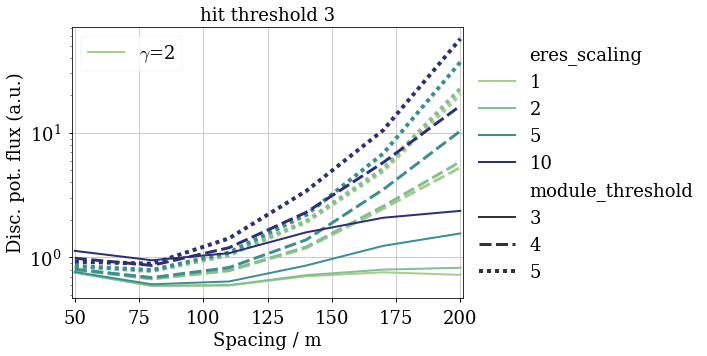

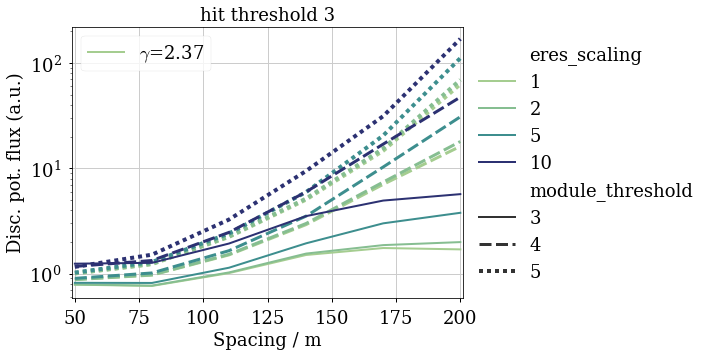

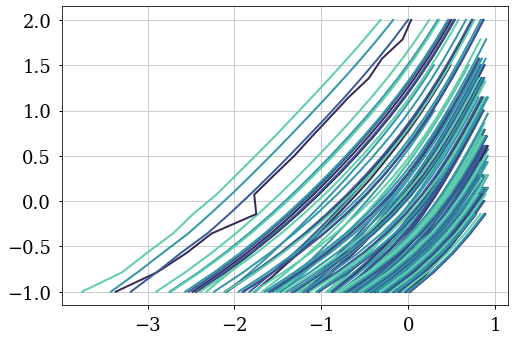

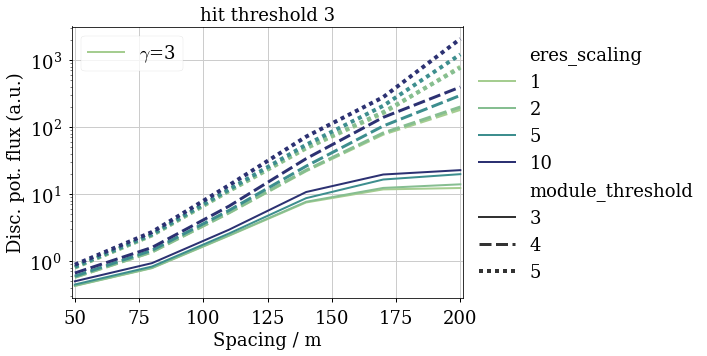

In [25]:
for gamma in gammas:
    selection = pd.read_pickle(
        join(
            BASEPATH,
            f"resources/casc_diffuse_significance_cluster_gamma-{gamma}_escaling_DP.pckl",
        )
    )

    DPs = []
    gb_names = ["hit_threshold", "module_threshold", "spacing", "eres_scaling"]
    for config, series in selection.groupby(gb_names):
        mask = np.isfinite(series.sigma)
        try:
            func_inv = np.poly1d(
                np.polyfit(
                    np.log10(series[mask].sigma),
                    np.log10(series[mask].flux_scale),
                    2,
                )
            )

            sigma5_DP = 10 ** func_inv(np.log10(5))
        except:
            sigma5_DP = np.nan
        plt.figure(1)
        plt.plot(
            np.log10(series[mask].sigma),
            np.log10(series[mask].flux_scale),
        )
        tmp = {key: val for key, val in zip(gb_names, config)}
        tmp["DP_flux"] = sigma5_DP
        DPs.append(tmp)
    DPs = pd.DataFrame(DPs)

    hts = DPs.hit_threshold.unique()
    f, axes = plt.subplots(ncols=len(hts), figsize=(7 * len(hts), 5))

    for ii, ht in enumerate(hts):
        condition = DPs.hit_threshold == ht
        ax = sns.lineplot(
            data=DPs.loc[condition],
            y="DP_flux",
            x="spacing",
            hue="eres_scaling",
            palette="crest",
            style="module_threshold",
            size="module_threshold",
            sizes=(2, 4),
            ax=axes[ii] if len(hts) > 1 else axes,
        )
        ax.set_title(f"hit threshold {ht}")
        ax.set_ylabel("Disc. pot. flux (a.u.)")
        ax.set_xlabel("Spacing / m")
        if ii == 0:
            lg = f.legend(
                ncol=1,
                loc="center left",
                bbox_to_anchor=(0.9, 0.5),
                frameon=False,
            )
        ax.legend([rf"$\gamma$={gamma}"])
        ax.set_xlim(49, 201)
        # ax.set_ylim(0.5, 10)
        ax.semilogy()


## Livetime scaling

In [ ]:
c_names = np.asarray(aeffs.index.names)
mask = (
    (aeffs.index.get_level_values("spacing") == 110)
    & (aeffs.index.get_level_values("module_threshold") == 3)
    & (aeffs.index.get_level_values("hit_threshold") == 3)
)
flux_def = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")

full_det = False
diff_significances = []
flux_scalings = np.logspace(-0.5, 1, num=20)
livetimes = np.logspace(0, 1.7, num=20)
current_config = copy(diff_config)


In [ ]:
for livetime, flux_scale, (config, aeff) in product(livetimes, flux_scalings, aeffs.loc[mask].iterrows()):
    current_config["livetime"] = livetime * 3600 * 24 * 365
    if full_det:
        aeff *= 7  # full detector
    tmp = {key: val for key, val in zip(c_names, config)}
    aeff_test = aeff["equatorial_fine"]
    reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
    aeff_factor = calc_aeff_factor(aeff_test, **current_config)
    k_s = astro_flux(
        aeff_factor,
        emids,
        normed_kvals=reso_test.energy_res,
        phi_scaling=flux_scale,
        flux_shape=flux_def,
    )

    k_b = atmo_background(
        aeff_factor,
        spl_vals,
        normed_kvals=reso_test.energy_res,
    )

    mu_base = np.copy(aeff_factor)
    k_i = k_s + k_b

    tmp["nb"] = np.sum(k_b)
    tmp["ns"] = np.sum(k_s)
    tmp["flux_scale"] = flux_scale
    tmp["livetime"] = livetime

    fit_config = dict(
        mu_b_base=aeff_factor,
        mu_s_base=aeff_factor,
        k_i=k_i,
        e_0=flux_def.E0,
        phi_0=flux_def.norm,
        shape="powerlaw",
        normed_kvals=reso_test.energy_res,
    )
    # fix signal contribution to 0
    local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
    global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        bounds=[(1e-3, 1e2)],
        approx_grad=True,
    )
    tmp["bg_atmo_norm"] = out_bckg[0][0]

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.0, 1.0, 2.3),
        bounds=[(1e-3, 1e2), (1e-3, 1e2), (1.5, 3.5)],
        approx_grad=True,
        factr=10,
    )
    # tmp["status"] = out_comp[2]["warnflag"]
    # tmp["comb_atmo_norm"] = out_comp[0][0]
    # tmp["comb_astro_norm"] = out_comp[0][1]
    # tmp["comb_astro_gamma"] = out_comp[0][2]
    # tmp["-2DLLH"] = out_bckg[1] - out_comp[1]
    # tmp["bg_TS"] = out_bckg[1]
    # tmp["comb_TS"] = out_comp[1]
    tmp["check_TS"] = global_llh((1, 1, GAMMA_ASTRO))

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = erfinv(1 - pval) * np.sqrt(2)
    tmp["pval"] = pval
    tmp["sigma"] = significance
    tmp["check_sigma"] = erfinv(
        1 - chi2.sf(out_bckg[1] - tmp["check_TS"], 2)
    ) * np.sqrt(2)
    diff_significances.append(tmp)

diff_significances = pd.DataFrame(diff_significances)

diff_significances["sigma_cut"] = 7
diff_significances.loc[
    diff_significances["sigma"] <= 7, "sigma_cut"
] = diff_significances.loc[diff_significances["sigma"] <= 7, "sigma"]
add = "full" if full_det else "cluster"
pd.to_pickle(
    diff_significances,
    join(
        BASEPATH,
        f"resources/casc_diffuse_significance_{add}_gamma-{flux_def.gamma}_DP.pckl",
    ),
)


### plotting

In [ ]:
diff_significances_cluster = pd.read_pickle(
    join(BASEPATH, f"resources/casc_diffuse_significance_cluster_gamma-{flux_def.gamma}_DP.pckl")
)

selection = diff_significances_cluster.loc[
    (diff_significances_cluster.hit_threshold >= 3)
    & (diff_significances_cluster.module_threshold >= 3)
    & (diff_significances_cluster.spacing == 110)
]

f, ax = plt.subplots()
ncols = len(selection.module_threshold.unique())

condition = (selection.min_pos_resolution.isna()) & (selection.hit_threshold == 3)

ax = sns.scatterplot(
    data=selection.loc[condition],
    y="sigma",
    x="flux_scale",
    hue="livetime",
    #hue="module_threshold",
    #style="hit_threshold",
    palette="crest",
    ax=ax,
    s=150,
)
# get scatterblobs to extract color (black magic)
blobs = [r for r in ax.get_children() if type(r)==PathCollection]

lg = ax.get_legend()

# for lh in lg.legendHandles:
#     lh._sizes = [150]
lg.set_title("Livetime / yr")
title = lg.get_title()
title.set_fontsize(15)


# make a fit to livetime scaling
# log10(sigma) = c1 log10(lt)^2 + c2 log10(lt) + c3
i=1
DPs = []
for lt, series in selection.loc[condition].groupby("livetime"):
    mask = np.isfinite(series.sigma)
    func = np.poly1d(
        np.polyfit(
            np.log10(series[mask].flux_scale),
            np.log10(series[mask].sigma),
            2,
        )
    )

    func_inv = np.poly1d(
        np.polyfit(
            np.log10(series[mask].sigma),
            np.log10(series[mask].flux_scale),
            2,
        )
    )

    sigma5_DP = 10**func_inv(np.log10(5))
    p = ax.plot(flux_scalings, 10**func(np.log10(flux_scalings))) #, color=blobs[i].get_facecolor())
    ax.axvline(sigma5_DP, color=p[0].get_color(), ls="--")
    DPs.append(sigma5_DP)
    i += 1

ax.set_ylabel(r"Significance / a.u.")
ax.set_xlabel("phi * factor")
ax.set_title(rf"Power-law $\gamma$=-{flux_def.gamma}")

f.tight_layout()
# f.savefig(join(BASEPATH, "plots/cascades_diff_significances.png"))

ax.loglog()
ax.axhline(5, ls="--")


 
-0.8232 x + 0.8468


Text(0.5, 1.0, 'Diffuse flux discovery potential (10-Str cluster)')

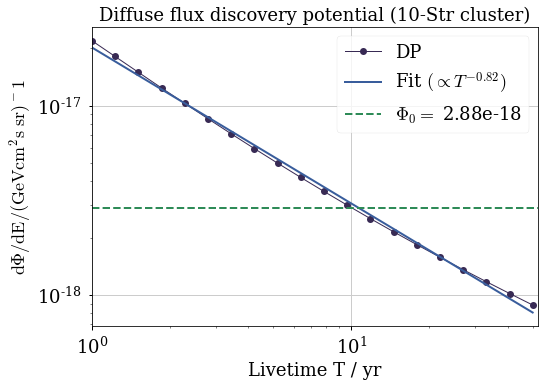

In [ ]:
DPs = np.array(DPs)
f, ax = plt.subplots()
ax.plot(livetimes, DPs * flux_def.norm, lw=1, marker="o", label="DP")
ax.set_ylabel(r"${\rm d\Phi/dE /( GeV cm^2 s\ sr)^-1}$")
ax.set_xlabel("Livetime T / yr")
ax.set_xlim(1)
fit_func = np.poly1d(np.polyfit(np.log10(livetimes), np.log10(DPs), 1))
print(fit_func)
lts = np.linspace(1, 50)
ax.plot(lts, 10**fit_func(np.log10(lts)) * flux_def.norm, label=fr"Fit $(\propto T^{{{fit_func.coef[0]:1.2f}}})$")
ax.axhline(flux_def.norm, label=fr"$\Phi_0 =$ {flux_def.norm:1.2e}", ls="--", color="seagreen")
ax.legend()
ax.loglog()
ax.set_title("Diffuse flux discovery potential (10-Str cluster)")

# PS angular scaling

In [55]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    verbose=False,
):
    """fit parameters in x:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2:]: other signal parameters
        see 'astro_flux' for further shapes and parameters

    mu_b_base: background baseline
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_0: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape
    """
    mu_b = mu_b_base * x[0]
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    if verbose:
        print(x[0], x[1], *x[2:])
        print(flux_collection[shape](phi_0, *x[2:], e_0, shape))
        print(np.sum(mu_b), np.sum(mu_s))
    mu_i = mu_s + mu_b

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


In [56]:
from tools import array_source_interp

In [57]:
resolution_df_energy = pd.read_pickle(
    join(BASEPATH, "resources/optimization_resolutions_energy_raw.pickle")
)
resolution_df_energy = resolution_df_energy.set_index(["config", "spacing", "pmts"])

resolution_df_psi = pd.read_pickle(
    join(BASEPATH, "resources/optimization_resolutions_psi_raw.pickle")
)
resolution_df_psi = resolution_df_psi.set_index(["config", "spacing", "pmts"])

sindec_bins_fine, logE_bins_fine, aeffs = pd.read_pickle(
    join(BASEPATH, "resources/aeff_cluster_nuecc_with-eq.pickle")
)

# different binning
logE_bins = np.linspace(
    np.min(logE_bins_fine),
    np.max(logE_bins_fine),
    num=np.shape(aeffs["equatorial"].iloc[0])[0]+1,
)
sindec_bins = np.linspace(
    np.min(sindec_bins_fine),
    np.max(sindec_bins_fine),
    num=np.shape(aeffs["equatorial"].iloc[0])[1]+1,
)
sindec_mids = get_mids(sindec_bins)
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals_raw = np.exp(rgi_bg((ee, ss)))


In [58]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=sindec_mids,
    livetime=LIVETIME * 10,
    ewidth=ewidth,
    dpsi_max=0,
    grid_2d=1,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = 15
bg_config["grid_2d"] = 1

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = ngc1068.dec.rad


In [59]:
# livetime of 1yr in seconds
LIVETIME = 365 * 1 * 24 * 3600
# 10yr PS PAPER PARAMETERS
GAMMA_NGC = 3.2
PHI_NGC = 5E-14 * 2 # numu + numubar -> nue+nuebar + nutau+nutaubar
E0_NGC = 1E3

# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")

## setup

In [60]:
from scipy.stats import gamma as scgamma

In [61]:
psi_scalings = [0.01, 0.1, 1]
pdlist = []
c_names = np.asarray(aeffs.index.names)
aeff_selection_mask = (
    (aeffs.index.get_level_values("module_threshold") >= 3)
    & (aeffs.index.get_level_values("hit_threshold") == 3)
    & (aeffs.index.get_level_values("spacing") >= 50)
    & np.isnan(aeffs.index.get_level_values("min_pos_resolution"))
)
for psc, (config, aeff) in product(
    psi_scalings, aeffs.loc[aeff_selection_mask].iterrows()
):

    ident = ("Full pessimistic cluster", config[-1], slice(None), 16)
    series = fisher.loc[ident]
    true_E = series.index.get_level_values(0).values
    width_psi = series.ang_res_sampl.values

    ## psi
    mask = np.isfinite(width_psi)
    fit_wps = np.poly1d(np.polyfit(np.log10(true_E), np.log10(width_psi), 1))
    ## based on psi²
    psi_max = 5 * psc * 10 ** fit_wps(logE_mids[0])
    if psi_max > 90:
        psi_max = 90
    reso_psi2_bins = np.linspace(0, psi_max**2, num=151)
    reso_psi2_mids = get_mids(reso_psi2_bins)
    psi2_all = []
    for et in logE_mids:
        # scale angular error
        tmp_psi = psc * 10 ** fit_wps(et)
        # integrate over bin
        tmp = scgamma.cdf(reso_psi2_bins[1:], 1, scale=2 * tmp_psi**2) - scgamma.cdf(
            reso_psi2_bins[:-1], 1, scale=2 * tmp_psi**2
        )
        psi2_all.append(tmp / np.sum(tmp))
    psi2_all = np.array(psi2_all).T

    dct = {key: val for key, val in zip(c_names, config)}
    dct["etrue_bins"] = logE_bins
    dct["psi2"] = psi2_all
    dct["psi2_bins"] = reso_psi2_bins
    dct["psi_scaling"] = psc
    pdlist.append(dct)
psi_resolution = pd.DataFrame(pdlist).set_index(
    [
        "psi_scaling",
        "hit_threshold",
        "module_threshold",
        "min_pos_resolution",
        "spacing",
    ]
)


## fitting

In [66]:
c_names = np.asarray(aeffs.index.names)
gammas = [2, 2.5, 3]
num = 10
flux_scalings = {
    2: np.logspace(-1.5, 0.5, num=num),
    2.5: np.logspace(0, 2, num=num),
    3: np.logspace(0, 3.5, num=num),
}
for gamma in gammas:
    ps_significances = []
    for psc, flux_scale, (config, aeff) in product(
        psi_scalings, flux_scalings[gamma], aeffs.loc[aeff_selection_mask].iterrows()
    ):
        # aeff *= 20  # very large detector :) for fun (and ps)
        flux_def = PL_flux(PHI_NGC * flux_scale, gamma, E0_NGC, "powerlaw")

        tmp = {key: val for key, val in zip(c_names, config)}
        aeff_test = aeff["equatorial"]

        indices = [psc]
        indices.extend(config)
        reso_test = psi_resolution.loc[tuple(indices)]
        reso_test_E = resolution_df_energy.loc[
            "Full pessimistic cluster", config[-1], 16
        ]
        bckg_grid = np.ones_like(reso_test.psi2)
        bckg_grid /= np.sum(bckg_grid, axis=0)
        ngc_bg_config["grid_2d"] = bckg_grid
        ngc_src_config["grid_2d"] = reso_test.psi2
        bg_config["dpsi_max"] = np.sqrt(reso_test.psi2_bins[-1])
        ngc_bg_config["dpsi_max"] = np.sqrt(reso_test.psi2_bins[-1])
        aeff_factor_bckg = calc_aeff_factor(aeff_test, **ngc_bg_config)
        aeff_factor_signal = calc_aeff_factor(aeff_test, **ngc_src_config)

        # asimov data
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(ngc1068.dec.rad, spl_vals_raw.T, sindec_mids).T,
            normed_kvals=reso_test_E.energy_res,
        )
        k_s = astro_flux(
            aeff_factor_signal,
            emids,
            phi_scaling=1,
            normed_kvals=reso_test_E.energy_res,
            flux_shape=flux_def,  # powerlaw
        )
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)
        tmp["flux_scale"] = flux_scale
        tmp["log_psi_scaling"] = np.log10(psc)

        # fix signal contribution to 0
        fit_config = dict(
            shape="powerlaw",
            mu_b_base=k_b,
            mu_s_base=aeff_factor_signal,
            k_i=k_i,
            e_0=flux_def.E0,
            phi_0=flux_def.norm,
            normed_kvals=reso_test_E.energy_res,
        )
        local_llh = lambda x: ps_llh_2d_composite((x[0], 0, 3), **fit_config)
        global_llh = lambda x: ps_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.2,),
            approx_grad=True,
        )
        tmp["out_bg"] = out_bckg[0]

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.2, 1.2, 3.0),
            approx_grad=True,
        )
        tmp["out_sig"] = out_comp[0]
        tmp["-2DLLH"] = out_bckg[1] - out_comp[1]

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        tmp["pval"] = pval
        tmp["sigma"] = significance
        ps_significances.append(tmp)

    ps_significances = pd.DataFrame(ps_significances)
    pd.to_pickle(
        ps_significances,
        join(BASEPATH, f"resources/casc_ps_significance_psi_scaling_gamma{gamma}.pckl"),
    )


## plotting

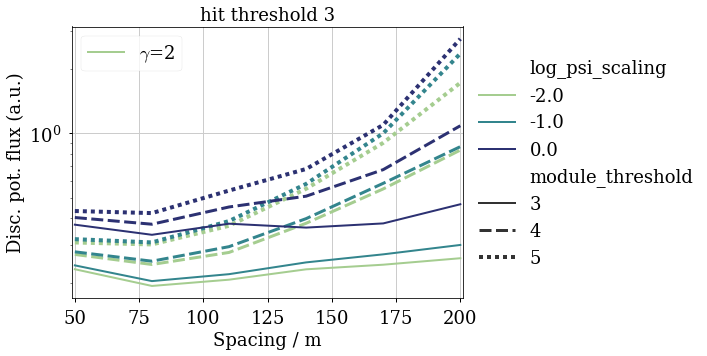

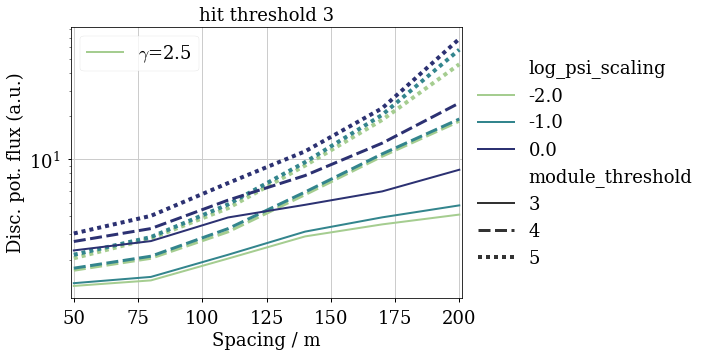

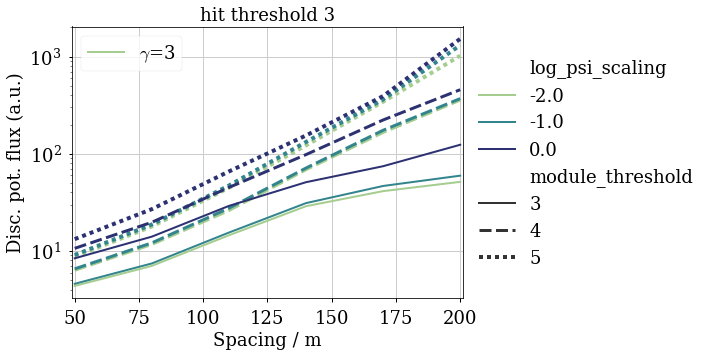

In [67]:
for gamma in gammas:
    selection = pd.read_pickle(
        join(
            BASEPATH,
            f"resources/casc_ps_significance_psi_scaling_gamma{gamma}.pckl",
        )
    )

    DPs = []
    gb_names = ["hit_threshold", "module_threshold", "spacing", "log_psi_scaling"]
    for config, series in selection.groupby(gb_names):
        mask = np.isfinite(series.sigma)
        try:
            func_inv = np.poly1d(
                np.polyfit(
                    np.log10(series[mask].sigma),
                    np.log10(series[mask].flux_scale),
                    2,
                )
            )

            sigma5_DP = 10 ** func_inv(np.log10(5))
        except:
            sigma5_DP = np.nan

        tmp = {key: val for key, val in zip(gb_names, config)}
        tmp["DP_flux"] = sigma5_DP
        DPs.append(tmp)
    DPs = pd.DataFrame(DPs)

    hts = DPs.hit_threshold.unique()
    f, axes = plt.subplots(ncols=len(hts), figsize=(7 * len(hts), 5))

    for ii, ht in enumerate(hts):
        condition = DPs.hit_threshold == ht
        # condition = (DPs.module_threshold==3) & (DPs.hit_threshold==ht)
        ax = sns.lineplot(
            data=DPs.loc[condition],
            y="DP_flux",
            x="spacing",
            hue="log_psi_scaling",
            palette="crest",
            style="module_threshold",
            size="module_threshold",
            sizes=(2, 4),
            ax=axes[ii] if len(hts) > 1 else axes,
        )
        ax.set_title(f"hit threshold {ht}")
        ax.set_ylabel("Disc. pot. flux (a.u.)")
        ax.set_xlabel("Spacing / m")
        if ii == 0:
            lg = f.legend(
                ncol=1,
                loc="center left",
                bbox_to_anchor=(0.9, 0.5),
                frameon=False,
            )
        ax.legend([rf"$\gamma$={gamma}"])
        ax.set_xlim(49, 201)
        # ax.set_ylim(0.5, 10)
        ax.semilogy()
    # break
